In [1]:
import astropy.units as u
import numpy as np
from matplotlib import pyplot as plt
from astroduet.bbmag import bb_abmag_fluence, bb_abmag

import astroduet.config as config
from astroduet.background import background_pixel_rate
from astroduet.utils import duet_abmag_to_fluence


%load_ext autoreload
%autoreload 2

from astropy.visualization import quantity_support
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# Account for the fact that you're co-adding the two frames here:
duet = config.Telescope(config='minimum_mass_requirement')



In [2]:
# From Marianne:

# Using the median surface brightnesses from Bai:

# Elliptical, D1: 0.56 ph/s/pixel
# Elliptical, D2: 0.64 ph/s/pixel
# Spiral, D1: 2.09 ph/s/pixel
# Spiral, D2: 1.68 ph/s/pixel

pixel_area = duet.pixel * duet.pixel

mean_elliptical_duet1 =  24.94535864867936 * u.ABmag 
mean_elliptical_duet2 = 24.730938046220277 * u.ABmag

mean_spiral_duet1 = 23.684754905932877 * u.ABmag
mean_spiral_duet2 = 23.827616937816682 * u.ABmag


rate1 = pixel_area.value * duet.fluence_to_rate(duet_abmag_to_fluence(mean_elliptical_duet1, 1))
#rate1 = pixel_area.value * duet.fluence_to_rate(duet_abmag_to_fluence(mean_spiral_duet1, 1))


print(rate1)

rate2 = pixel_area.value * duet.fluence_to_rate(duet_abmag_to_fluence(mean_elliptical_duet2, 2))
#rate2 = pixel_area.value * duet.fluence_to_rate(duet_abmag_to_fluence(mean_spiral_duet2, 2))


print(rate2)



0.3913039939914652 ph / s
0.44584359485418784 ph / s


In [3]:

# Band1
# 5-sigma limiting magnitude in 1 and 5 stacked frames.

# Account for the fact that you're co-adding the two frames here:
duet = config.Telescope(config='minimum_mass_requirement')

bandone = duet.bandpass1
bandtwo = duet.bandpass2

surf_scale = 1.0

exposure = 300*u.s
print()
siglimit=5
dmag = 0.01
print()
[bgd_band1, bgd_band2] = background_pixel_rate(duet, med_zodi=True)


tot_bgd_rate = bgd_band1  + rate1 * surf_scale

for nframes in [8]:
    snr = 100
    swiftmag = 20.5
    while snr > siglimit:
        swiftmag += dmag
        band1_fluence, band2_fluence = bb_abmag_fluence(duet =duet, swiftmag=swiftmag*u.ABmag, bbtemp=12e3*u.K)
        band1_rate = duet.fluence_to_rate(band1_fluence)
        band2_rate = duet.fluence_to_rate(band2_fluence)
        src_rate = band1_rate

        snr = duet.calc_snr(exposure, src_rate, tot_bgd_rate, nint=nframes)
    bbmag1, bbmag2 = bb_abmag(swiftmag=swiftmag*u.ABmag, bbtemp=12e3*u.K, bandone = bandone, bandtwo=bandtwo) 
    print('Band1 {} {}-σ magnitude limit: {}'.format(nframes*exposure, siglimit, bbmag1))
    print(snr)
duet1_limit = bbmag1

tot_bgd_rate = bgd_band2  + rate2*surf_scale
for nframes in [8]:
    snr = 100
    swiftmag = 20.8
    while snr > siglimit:
        swiftmag += dmag
        band1_fluence, band2_fluence = bb_abmag_fluence(duet =duet, swiftmag=swiftmag*u.ABmag, bbtemp=12e3*u.K)
        band1_rate = duet.fluence_to_rate(band1_fluence)
        band2_rate = duet.fluence_to_rate(band2_fluence)
        src_rate = band2_rate

        snr = duet.calc_snr(exposure, src_rate, tot_bgd_rate, nint=nframes)
    bbmag1, bbmag2 = bb_abmag(swiftmag=swiftmag*u.ABmag, bbtemp=12e3*u.K, bandone = bandone, bandtwo=bandtwo) 

    print('Band2 {} {}-σ magnitude limit: {}'.format(nframes*exposure, siglimit, bbmag2))
    print(snr)
    print()


duet2_limit = bbmag2



Band1 2400.0 s 5-σ magnitude limit: 21.643687613578173 mag(AB)
4.964575476786172
Band2 2400.0 s 5-σ magnitude limit: 21.33988223107127 mag(AB)
4.988049695552248



In [89]:
from astroduet import models

In [22]:
sims = models.Simulations()
sims.emgw_simulations

131.74734760504631 Mpc
172.66808035618604 Mpc


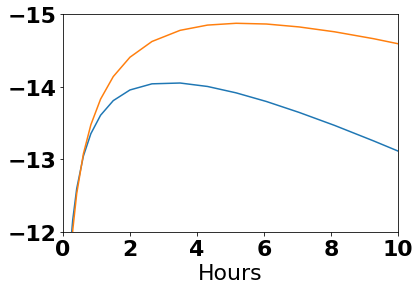

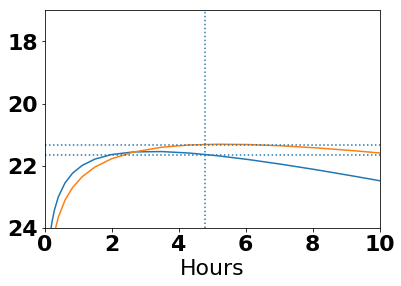

308.9011627627206 Mpc
316.2467611267618 Mpc


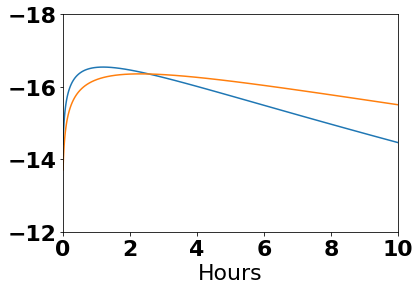

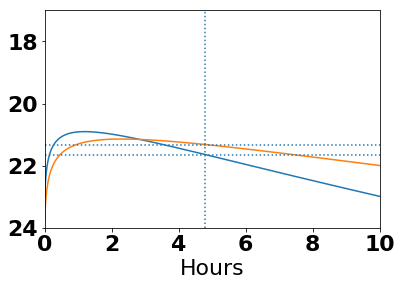

In [160]:
target = 0.2 *u.day

lc = models.load_model_ABmag('kilonova_0.02.dat', dist = 10*u.pc)
duet1_abmag_at_5hr = np.interp(target.to(u.s).value, lc[0].to(u.s).value, lc[1])
duet2_abmag_at_5hr = np.interp(target.to(u.s).value, lc[0].to(u.s).value, lc[2])

hrs = lc[0].to(u.hr)


plt.figure()
plt.plot(hrs, lc[1])
plt.plot(hrs, lc[2])
plt.ylim([-12, -15])
plt.xlim([0, 10])
plt.xlabel('Hours')

plt.figure()

dist1 = 10 * 10**((duet1_limit.value - duet1_abmag_at_5hr) / 5)*u.pc
print(dist1.to(u.Mpc))
dist2 = 10 * 10**((duet2_limit.value - duet2_abmag_at_5hr) / 5)*u.pc
print(dist2.to(u.Mpc))


lc1 = models.load_model_ABmag('kilonova_0.02.dat', dist = dist1)
plt.plot(hrs, lc1[1])

lc2 = models.load_model_ABmag('kilonova_0.02.dat', dist = dist2)
plt.plot(hrs, lc2[2])

plt.axhline(duet1_limit.value, linestyle = ':')
plt.axhline(duet2_limit.value, linestyle = ':')

plt.axvline(target.to(u.hr).value, linestyle=':')
plt.ylim([24, 17])
plt.xlim([0, 10])
plt.xlabel('Hours')
plt.show()




lc = models.load_model_ABmag('shock_5e10.dat', dist = 10*u.pc)
duet1_abmag_at_5hr = np.interp(target.to(u.s).value, lc[0].to(u.s).value, lc[1])
duet2_abmag_at_5hr = np.interp(target.to(u.s).value, lc[0].to(u.s).value, lc[2])

hrs = lc[0].to(u.hr)



plt.figure()
plt.plot(hrs, lc[1])
plt.plot(hrs, lc[2])
plt.ylim([-12, -18])
plt.xlim([0, 10])
plt.xlabel('Hours')

plt.figure()

dist1 = 10 * 10**((duet1_limit.value - duet1_abmag_at_5hr) / 5)*u.pc
print(dist1.to(u.Mpc))
dist2 = 10 * 10**((duet2_limit.value - duet2_abmag_at_5hr) / 5)*u.pc
print(dist2.to(u.Mpc))


lc1 = models.load_model_ABmag('shock_5e10.dat', dist = dist1)
plt.plot(hrs, lc1[1])

lc2 = models.load_model_ABmag('shock_5e10.dat', dist = dist2)
plt.plot(hrs, lc2[2])

plt.axhline(duet1_limit.value, linestyle = ':')
plt.axhline(duet2_limit.value, linestyle = ':')

plt.axvline(target.to(u.hr).value, linestyle=':')
plt.ylim([24, 17])
plt.xlim([0, 10])
plt.xlabel('Hours')
plt.show()



